Cosine similarity between text and image: 0.24656033515930176


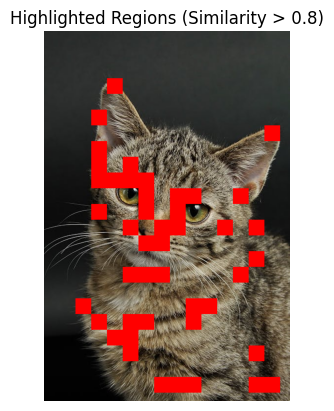

In [3]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image = Image.open("data/image.png")
image = image.convert("RGB")
image_np = np.array(image)

text_prompt = "ears of the cat"

inputs = processor(text=text_prompt, images=image, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)
    image_embeds = outputs.image_embeds
    text_embeds = outputs.text_embeds

similarity = torch.cosine_similarity(image_embeds, text_embeds)
print(f"Cosine similarity between text and image: {similarity.item()}")

patch_size = 32 
height, width, _ = image_np.shape
patches = []

for i in range(0, height, patch_size):
    for j in range(0, width, patch_size):
        patch = image_np[i:i+patch_size, j:j+patch_size]
        patches.append((patch, (i, j)))

patch_similarities = []

for patch, (i, j) in patches:
    patch_image = Image.fromarray(patch)
    inputs_patch = processor(text=text_prompt, images=patch_image, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs_patch = model(**inputs_patch)
        image_embeds_patch = outputs_patch.image_embeds
        similarity_patch = torch.cosine_similarity(image_embeds_patch, text_embeds)
        patch_similarities.append((similarity_patch.item(), (i, j, patch)))

similarities = [sim for sim, _ in patch_similarities]
scaler = MinMaxScaler()
normalized_similarities = scaler.fit_transform(np.array(similarities).reshape(-1, 1))

highlighted_image = image_np.copy()

for (similarity_value, (i, j, patch)), norm_similarity in zip(patch_similarities, normalized_similarities):
    if norm_similarity > 0.7: 
        highlighted_image[i:i+patch_size, j:j+patch_size] = np.array([255, 0, 0])

plt.imshow(highlighted_image)
plt.title(f"Highlighted Regions (Similarity > 0.8)")
plt.axis("off")
plt.show()


In [ ]:
# Use SAM2 with images
import torch


predictor = SAM2ImagePredictor.from_pretrained(facebook/sam2-hiera-large)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(<your_image>)
    masks, _, _ = predictor.predict(<input_prompts>)

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import CLIPProcessor, CLIPModel

# Load OpenCLIP model
clip_model, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
tokenizer = open_clip.get_tokenizer("ViT-B-32")

# Load SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to(device)
sam_predictor = SamPredictor(sam)

def load_image(image_path):
    """Load an image and convert to RGB."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def segment_image(image):
    """Generate segmentation proposals using SAM."""
    sam_predictor.set_image(image)
    h, w, _ = image.shape
    grid_points = np.array([[x, y] for y in np.linspace(0, h, 10) for x in np.linspace(0, w, 10)])
    masks, _, _ = sam_predictor.predict(grid_points)
    return masks

def match_text_to_segment(image, masks, text_query):
    """Use OpenCLIP to match text query to the best segmentation."""
    image_patches = []
    bboxes = []

    for mask in masks:
        x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))
        cropped = image[y:y+h, x:x+w]
        image_patches.append(cropped)
        bboxes.append((x, y, w, h))

    # Convert text query to CLIP embedding
    text_inputs = tokenizer([text_query])
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)

    similarities = []
    for patch in image_patches:
        patch_resized = cv2.resize(patch, (224, 224))  # Resize for CLIP
        patch_tensor = preprocess(patch_resized).unsqueeze(0)

        with torch.no_grad():
            image_features = clip_model.encode_image(patch_tensor)

        similarity = torch.nn.functional.cosine_similarity(text_features, image_features)
        similarities.append(similarity.item())

    # Get best match
    best_match_idx = np.argmax(similarities)
    return bboxes[best_match_idx]

def draw_bounding_box(image, bbox):
    """Draw bounding box on the image."""
    x, y, w, h = bbox
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 3)
    plt.imshow(image_with_box)
    plt.axis("off")
    plt.show()

# Example Usage
image_path = "cat.jpg"  # Replace with your image
text_query = "the ear of the cat"  # Change dynamically for other parts

image = load_image(image_path)
masks = segment_image(image)
best_bbox = match_text_to_segment(image, masks, text_query)
draw_bounding_box(image, best_bbox)


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForMaskGeneration, CLIPProcessor, CLIPModel
from huggingface_hub import hf_hub_download

# =======================
# 1️⃣ Load SAM from Hugging Face
# =======================
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load SAM with Transformers API
processor_sam = AutoProcessor.from_pretrained("facebook/sam-vit-huge")
model_sam = AutoModelForMaskGeneration.from_pretrained("facebook/sam-vit-huge").to(device)

# =======================
# 2️⃣ Load OpenCLIP from Hugging Face
# =======================
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# =======================
# 3️⃣ Load and Process Image
# =======================
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# =======================
# 4️⃣ Use SAM to Generate Segments
# =======================
def segment_image(image):
    """Generate segmentation masks using SAM and convert them to binary masks."""
    inputs = processor_sam(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_sam(**inputs)
    
    # Convert to numpy and ensure it's a binary uint8 mask
    masks = outputs.pred_masks.squeeze(1).cpu().numpy()
    binary_masks = (masks > 0.5).astype(np.uint8)  # Convert to 0-1 binary mask
    
    return binary_masks


# =======================
# 5️⃣ Match Text Query to Segments using CLIP
# =======================
def match_text_to_segment(image, masks, text_query):
    """Find the best-matching segment based on the text query."""
    image_patches = []
    bboxes = []

    for mask in masks:
        # Ensure the mask is uint8 (0 or 255)
        mask_uint8 = (mask * 255).astype(np.uint8)  
        
        # Find bounding box
        x, y, w, h = cv2.boundingRect(mask_uint8)
        
        # Crop the image
        cropped = image[y:y+h, x:x+w]
        image_patches.append(cropped)
        bboxes.append((x, y, w, h))

    # Tokenize the text query
    inputs = clip_processor(text=[text_query], return_tensors="pt").to(device)

    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)

    similarities = []
    for patch in image_patches:
        # Preprocess patch for CLIP
        patch_resized = cv2.resize(patch, (224, 224))
        patch_inputs = clip_processor(images=patch_resized, return_tensors="pt").to(device)

        with torch.no_grad():
            image_features = clip_model.get_image_features(**patch_inputs)

        similarity = torch.nn.functional.cosine_similarity(text_features, image_features)
        similarities.append(similarity.item())

    # Get best match
    best_match_idx = np.argmax(similarities)
    return bboxes[best_match_idx]


# =======================
# 6️⃣ Draw the Best-Matching Segment
# =======================
def draw_bounding_box(image, bbox):
    x, y, w, h = bbox
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 3)
    
    plt.imshow(image_with_box)
    plt.axis("off")
    plt.show()

# =======================
# 7️⃣ Run the System
# =======================
def run_text_to_segmentation(image_path, text_query):
    """Full pipeline to segment object parts using text queries."""
    image = load_image(image_path)
    masks = segment_image(image)
    best_bbox = match_text_to_segment(image, masks, text_query)
    draw_bounding_box(image, best_bbox)

# Example Usage
image_path = "data/image.png"  # Replace with your image
text_query = "the ear of the cat"  # Change dynamically for other parts

run_text_to_segmentation(image_path, text_query)


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4>, cv::impl::(anonymous namespace)::Set<1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>>::CvtHelper(InputArray, OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4>, VDcn = cv::impl::(anonymous namespace)::Set<1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 256


In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from segment_anything import SamPredictor, sam_model_registry
from transformers import AutoProcessor, AutoModelForMaskGeneration
from PIL import Image
import numpy as np

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load Segment Anything Model (SAM)
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Path to SAM checkpoint
model_type = "vit_h"
#sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda" if torch.cuda.is_available() else "cpu")
predictor = SamPredictor(sam)


processor = AutoProcessor.from_pretrained("facebook/sam-vit-huge")
model = AutoModelForMaskGeneration.from_pretrained("facebook/sam-vit-huge")

# Load and preprocess the image
image_path = "data/image.png"  # Path to your image
image = Image.open(image_path)
image_np = np.array(image)

# Generate image embeddings using CLIP
inputs = clip_processor(text=["the ear of the cat"], images=image, return_tensors="pt", padding=True)
with torch.no_grad():
    outputs = clip_model(**inputs)
    image_embeddings = outputs.image_embeds
    text_embeddings = outputs.text_embeds

# Generate segmentation masks using SAM
predictor.set_image(image_np)
masks, _, _ = predictor.predict()

# Match text embedding with image regions
# Compute similarity between text embedding and each mask region
mask_embeddings = []
for mask in masks:
    masked_image = image_np * mask[:, :, None]  # Apply mask to the image
    masked_image_pil = Image.fromarray(masked_image.astype(np.uint8))
    inputs = clip_processor(images=masked_image_pil, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    mask_embeddings.append(outputs)

mask_embeddings = torch.stack(mask_embeddings).squeeze()
similarities = torch.nn.functional.cosine_similarity(text_embeddings, mask_embeddings, dim=-1)

# Get the mask with the highest similarity
best_mask_idx = torch.argmax(similarities).item()
best_mask = masks[best_mask_idx]

# Generate bounding box from the best mask
y_indices, x_indices = np.where(best_mask > 0)
x_min, x_max = np.min(x_indices), np.max(x_indices)
y_min, y_max = np.min(y_indices), np.max(y_indices)
bounding_box = [x_min, y_min, x_max, y_max]

# Display or save the result
print("Bounding box for 'the ear of the cat':", bounding_box)

ModuleNotFoundError: No module named 'segment_anything'

In [ ]:
from transformers import pipeline
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained("facebook/sam-vit-huge")
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
input_points = [[[450, 600]]] # 2D localization of a window

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to("cuda")
outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

generator =  pipeline("mask-generation", device = 0, points_per_batch = 256)
image_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
outputs = generator(image_url, points_per_batch = 256)


import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

plt.imshow(np.array(raw_image))
ax = plt.gca()
for mask in outputs["masks"]:
    show_mask(mask, ax=ax, random_color=True)
plt.axis("off")
plt.show()


In [12]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="models/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
image_path = "data/image.png"
image = cv2.imread(image_path)
predictor.set_image(image)
masks, _, _ = predictor.predict()

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="models/sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(<your_image>)

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from segment_anything import sam_model_registry, SamPredictor

# Load CLIP model (text-image matching)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load Segment Anything Model (SAM)
sam_checkpoint = "models/sam_vit_h_4b8939.pth"  # Ensure you have the correct path
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
sam_predictor = SamPredictor(sam)

def load_image(image_path):
    """Load an image and convert it to RGB format."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def segment_image(image):
    """Generate segmentation proposals using SAM."""
    sam_predictor.set_image(image)
    h, w, _ = image.shape
    grid_points = np.array([[x, y] for y in np.linspace(0, h, 10) for x in np.linspace(0, w, 10)])
    masks, _, _ = sam_predictor.predict(point_coords=grid_points, point_labels=[1] * len(grid_points))
    return masks

def match_text_to_segment(image, masks, text_query):
    """Use CLIP to match text query to the best segmentation."""
    image_patches = []
    for mask in masks:
        x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))
        cropped = image[y:y+h, x:x+w]
        image_patches.append(cropped)

    # Convert patches into CLIP embeddings
    inputs = clip_processor(text=[text_query], images=image_patches, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    text_embeds = outputs.text_embeds
    image_embeds = outputs.image_embeds

    # Find the best matching patch
    similarity = torch.nn.functional.cosine_similarity(text_embeds, image_embeds)
    best_match_idx = torch.argmax(similarity).item()

    # Get bounding box of the best matching patch
    x, y, w, h = cv2.boundingRect(masks[best_match_idx].astype(np.uint8))
    return x, y, w, h

def draw_bounding_box(image, bbox):
    """Draw a bounding box on the image."""
    x, y, w, h = bbox
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 3)
    plt.imshow(image_with_box)
    plt.axis("off")
    plt.show()

# Example Usage
image_path = "data/image.png"  # Replace with your image
text_query = "the ear of the cat"

image = load_image(image_path)
masks = segment_image(image)
best_bbox = match_text_to_segment(image, masks, text_query)
draw_bounding_box(image, best_bbox)


ZeroDivisionError: division by zero

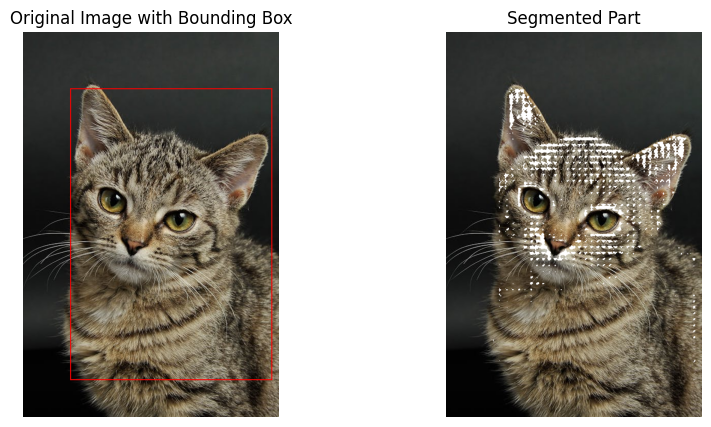

In [11]:
import torch
from transformers import CLIPProcessor, CLIPModel
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load Segment Anything Model (SAM)
sam_checkpoint = "models/sam_vit_h_4b8939.pth"  # Path to SAM checkpoint
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda" if torch.cuda.is_available() else "cpu")
predictor = SamPredictor(sam)

# Load and preprocess the image
image_path = "data/image.png"  # Path to your image
image = Image.open(image_path)
image_np = np.array(image)

# Generate image embeddings using CLIP
inputs = clip_processor(text=["ear"], images=image, return_tensors="pt", padding=True)
with torch.no_grad():
    outputs = clip_model(**inputs)
    image_embeddings = outputs.image_embeds
    text_embeddings = outputs.text_embeds

# Generate segmentation masks using SAM
predictor.set_image(image_np)
masks, _, _ = predictor.predict()

# Match text embedding with image regions
# Compute similarity between text embedding and each mask region
mask_embeddings = []
for mask in masks:
    masked_image = image_np * mask[:, :, None]  # Apply mask to the image
    masked_image_pil = Image.fromarray(masked_image.astype(np.uint8))
    inputs = clip_processor(images=masked_image_pil, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    mask_embeddings.append(outputs)

mask_embeddings = torch.stack(mask_embeddings).squeeze()
similarities = torch.nn.functional.cosine_similarity(text_embeddings, mask_embeddings, dim=-1)

# Get the mask with the highest similarity
best_mask_idx = torch.argmax(similarities).item()
best_mask = masks[best_mask_idx]

# Generate bounding box from the best mask
y_indices, x_indices = np.where(best_mask > 0)
x_min, x_max = np.min(x_indices), np.max(x_indices)
y_min, y_max = np.min(y_indices), np.max(y_indices)
bounding_box = [x_min, y_min, x_max, y_max]

# Visualize the segmented part
# Create a mask image
mask_image = Image.fromarray((best_mask * 255).astype(np.uint8))

# Overlay the mask on the original image
overlay = Image.new("RGBA", image.size, (0, 0, 0, 0))
overlay.paste(image, (0, 0))
overlay.paste(mask_image, (0, 0), mask=mask_image)

# Draw the bounding box on the original image
draw = ImageDraw.Draw(image)
draw.rectangle(bounding_box, outline="red", width=2)

# Display the results
plt.figure(figsize=(10, 5))

# Original image with bounding box
plt.subplot(1, 2, 1)
plt.title("Original Image with Bounding Box")
plt.imshow(image)
plt.axis("off")

# Segmented part of the image
plt.subplot(1, 2, 2)
plt.title("Segmented Part")
plt.imshow(overlay)
plt.axis("off")

plt.show()